In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(42)

batch_size = 64

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(root='./Py_CIFAR_Data/cifar_train', train=True, download=True, transform=train_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)


test_set = torchvision.datasets.CIFAR10(root='./Py_CIFAR_Data/cifar_test', train=False, download=True, transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Train size', len(train_set))
print('Test size', len(test_set))

100%|██████████| 170498071/170498071 [00:03<00:00, 55184123.82it/s]


Extracting ./cifar_train/cifar-10-python.tar.gz to ./cifar_train


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 170498071/170498071 [00:08<00:00, 19934684.96it/s]


Extracting ./cifar_test/cifar-10-python.tar.gz to ./cifar_test
Train size 50000
Test size 10000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_images(loader):
    inv_normalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 2, 2, 2 ]),
                                         transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ], std = [ 1., 1., 1. ])])

    images, labels = next(iter(loader))

    fig, axs = plt.subplots(figsize = (20, 20), ncols = 10)
    for n, image in enumerate(images):
        # Denormalize the images
        image = inv_normalize(image)
        image = image.permute(1,2,0)
        #image = (image - image.min()) / (image.max() - image.min())
        axs[n].imshow(image)
        axs[n].set_title(classes[labels.numpy()[n]])
        axs[n].axis('off')
        if n == 9:
            break
    plt.show()

Train (augmented) images.


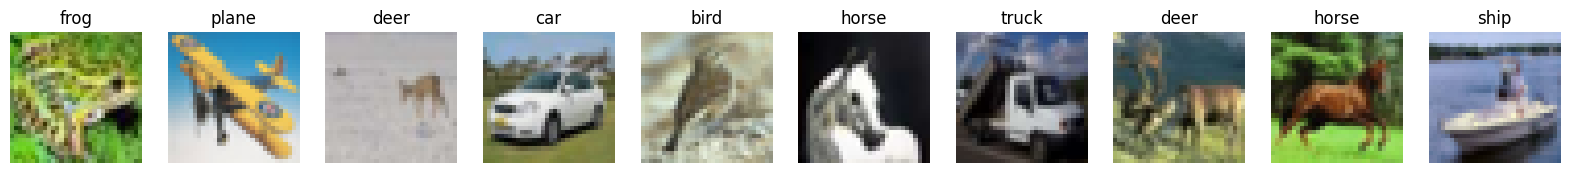

In [ ]:
print('Train (augmented) images.')
plot_random_images(train_loader)

Test images (no augmentation).


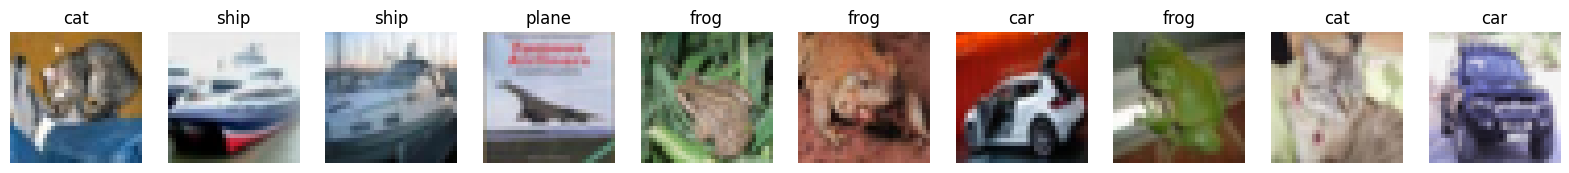

In [ ]:
print('Test images (no augmentation).')
plot_random_images(test_loader)

In [ ]:
def epoch_train(loader, clf, criterion, opt):
 
    clf.train(True)  # set the model to training mode
    total_loss, total_acc = [], []
    for X, y_true in loader:
        X, y_true = X.to(device), y_true.to(device)

        # forward pass and compute the loss
        y_pred = clf.forward(X)
        loss = criterion(y_pred, y_true)
        __, best_pred  = y_pred.max(axis=1)

        # zero the gradients
        opt.zero_grad()
        # backward pass and optimization step
        loss.backward()
        opt.step()

        # update the loss and accuracy
        total_loss.append(loss.item())
        total_acc.append(sum((best_pred == y_true)/ len(y_true)).item())
        

    avg_loss = sum(total_loss)/ len(loader)
    avg_acc = sum(total_acc) / len(loader)

    return avg_loss, avg_acc

def epoch_test(loader, clf, criterion):

    clf.eval()  # set the model to evaluation mode
    total_loss, total_acc = [], []
    
    for X, y_true in loader:
        X, y_true = X.to(device), y_true.to(device)

        # forward pass and compute the loss
        y_pred = clf.forward(X)
        loss = criterion(y_pred, y_true)
        __, best_pred  = y_pred.max(axis=1)
       
        # update the loss and accuracy
        total_loss.append(loss.item())
        total_acc.append(sum((best_pred == y_true)/ len(y_true)).item())
       
    avg_loss = sum(total_loss)/ len(loader)
    avg_acc = sum(total_acc) / len(loader)

    return avg_loss, avg_acc


# The function which you are going to use for model training
def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.Flatten(), 
            nn.Linear(3*32*32, 2048),
            nn.ReLU(),

            nn.Linear(2048,1024), 
            nn.ReLU(),

            nn.Linear(1024,512), 
            nn.ReLU(),  

            nn.Linear(512, num_classes)  
        )

    def forward(self, x):
        return self.layers(x)
    
clf_mlp = MLP(num_classes=10).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_mlp.parameters()]))

# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_mlp(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 10


Number of weights: 8921610


In [ ]:
clf_mlp = clf_mlp.to(device)
opt = torch.optim.SGD(clf_mlp.parameters(), lr=0.0001) 

criterion = nn.CrossEntropyLoss()

train(train_loader, test_loader, clf_mlp, criterion, opt, n_epochs=50)

  2%|▏         | 1/50 [00:19<16:11, 19.82s/it]

[Epoch 1] train loss: 2.304; train acc: 0.10; test loss: 2.303; test acc: 0.11


  4%|▍         | 2/50 [00:38<15:22, 19.21s/it]

[Epoch 2] train loss: 2.302; train acc: 0.11; test loss: 2.302; test acc: 0.11


  6%|▌         | 3/50 [00:58<15:19, 19.57s/it]

[Epoch 3] train loss: 2.301; train acc: 0.12; test loss: 2.301; test acc: 0.13


  8%|▊         | 4/50 [01:17<14:44, 19.22s/it]

[Epoch 4] train loss: 2.300; train acc: 0.13; test loss: 2.299; test acc: 0.14


 10%|█         | 5/50 [01:36<14:19, 19.09s/it]

[Epoch 5] train loss: 2.299; train acc: 0.14; test loss: 2.298; test acc: 0.15


 12%|█▏        | 6/50 [01:55<14:10, 19.33s/it]

[Epoch 6] train loss: 2.298; train acc: 0.15; test loss: 2.297; test acc: 0.15


 14%|█▍        | 7/50 [02:16<14:09, 19.76s/it]

[Epoch 7] train loss: 2.296; train acc: 0.15; test loss: 2.296; test acc: 0.16


 16%|█▌        | 8/50 [02:36<13:46, 19.68s/it]

[Epoch 8] train loss: 2.295; train acc: 0.16; test loss: 2.295; test acc: 0.17


 18%|█▊        | 9/50 [02:54<13:14, 19.38s/it]

[Epoch 9] train loss: 2.294; train acc: 0.17; test loss: 2.293; test acc: 0.17


 20%|██        | 10/50 [03:14<13:03, 19.59s/it]

[Epoch 10] train loss: 2.293; train acc: 0.18; test loss: 2.292; test acc: 0.18


 22%|██▏       | 11/50 [03:33<12:35, 19.38s/it]

[Epoch 11] train loss: 2.291; train acc: 0.19; test loss: 2.291; test acc: 0.19


 24%|██▍       | 12/50 [03:53<12:24, 19.59s/it]

[Epoch 12] train loss: 2.290; train acc: 0.20; test loss: 2.289; test acc: 0.20


 26%|██▌       | 13/50 [04:12<11:55, 19.33s/it]

[Epoch 13] train loss: 2.289; train acc: 0.20; test loss: 2.288; test acc: 0.21


 28%|██▊       | 14/50 [04:32<11:42, 19.51s/it]

[Epoch 14] train loss: 2.288; train acc: 0.21; test loss: 2.287; test acc: 0.21


 30%|███       | 15/50 [04:51<11:18, 19.40s/it]

[Epoch 15] train loss: 2.286; train acc: 0.22; test loss: 2.285; test acc: 0.22


 32%|███▏      | 16/50 [05:10<10:55, 19.28s/it]

[Epoch 16] train loss: 2.285; train acc: 0.22; test loss: 2.284; test acc: 0.22


 34%|███▍      | 17/50 [05:30<10:45, 19.56s/it]

[Epoch 17] train loss: 2.283; train acc: 0.22; test loss: 2.282; test acc: 0.23


 36%|███▌      | 18/50 [05:50<10:24, 19.51s/it]

[Epoch 18] train loss: 2.282; train acc: 0.23; test loss: 2.281; test acc: 0.23


 38%|███▊      | 19/50 [06:11<10:21, 20.06s/it]

[Epoch 19] train loss: 2.280; train acc: 0.23; test loss: 2.279; test acc: 0.23


 40%|████      | 20/50 [06:34<10:29, 20.99s/it]

[Epoch 20] train loss: 2.279; train acc: 0.23; test loss: 2.278; test acc: 0.24


 42%|████▏     | 21/50 [06:56<10:13, 21.15s/it]

[Epoch 21] train loss: 2.277; train acc: 0.24; test loss: 2.276; test acc: 0.24


 44%|████▍     | 22/50 [07:18<10:02, 21.50s/it]

[Epoch 22] train loss: 2.275; train acc: 0.24; test loss: 2.274; test acc: 0.24


 46%|████▌     | 23/50 [07:39<09:38, 21.41s/it]

[Epoch 23] train loss: 2.273; train acc: 0.24; test loss: 2.272; test acc: 0.24


 48%|████▊     | 24/50 [08:01<09:21, 21.60s/it]

[Epoch 24] train loss: 2.272; train acc: 0.24; test loss: 2.270; test acc: 0.25


 50%|█████     | 25/50 [08:22<08:51, 21.27s/it]

[Epoch 25] train loss: 2.270; train acc: 0.24; test loss: 2.268; test acc: 0.25


 52%|█████▏    | 26/50 [08:41<08:17, 20.75s/it]

[Epoch 26] train loss: 2.268; train acc: 0.25; test loss: 2.266; test acc: 0.25


 54%|█████▍    | 27/50 [09:01<07:48, 20.35s/it]

[Epoch 27] train loss: 2.265; train acc: 0.25; test loss: 2.264; test acc: 0.25


 56%|█████▌    | 28/50 [09:21<07:25, 20.23s/it]

[Epoch 28] train loss: 2.263; train acc: 0.25; test loss: 2.262; test acc: 0.25


 58%|█████▊    | 29/50 [09:40<06:59, 19.99s/it]

[Epoch 29] train loss: 2.261; train acc: 0.25; test loss: 2.259; test acc: 0.25


 60%|██████    | 30/50 [10:00<06:40, 20.04s/it]

[Epoch 30] train loss: 2.259; train acc: 0.25; test loss: 2.257; test acc: 0.25


 62%|██████▏   | 31/50 [10:20<06:16, 19.82s/it]

[Epoch 31] train loss: 2.256; train acc: 0.25; test loss: 2.254; test acc: 0.25


 64%|██████▍   | 32/50 [10:42<06:08, 20.48s/it]

[Epoch 32] train loss: 2.254; train acc: 0.25; test loss: 2.252; test acc: 0.26


 66%|██████▌   | 33/50 [11:01<05:41, 20.09s/it]

[Epoch 33] train loss: 2.251; train acc: 0.25; test loss: 2.249; test acc: 0.26


 68%|██████▊   | 34/50 [11:22<05:24, 20.30s/it]

[Epoch 34] train loss: 2.248; train acc: 0.25; test loss: 2.246; test acc: 0.26


 70%|███████   | 35/50 [11:41<05:00, 20.02s/it]

[Epoch 35] train loss: 2.245; train acc: 0.25; test loss: 2.243; test acc: 0.26


 72%|███████▏  | 36/50 [12:02<04:42, 20.18s/it]

[Epoch 36] train loss: 2.242; train acc: 0.25; test loss: 2.240; test acc: 0.26


 74%|███████▍  | 37/50 [12:21<04:18, 19.92s/it]

[Epoch 37] train loss: 2.239; train acc: 0.25; test loss: 2.237; test acc: 0.26


 76%|███████▌  | 38/50 [12:41<03:59, 19.99s/it]

[Epoch 38] train loss: 2.235; train acc: 0.25; test loss: 2.233; test acc: 0.26


 78%|███████▊  | 39/50 [13:00<03:37, 19.74s/it]

[Epoch 39] train loss: 2.232; train acc: 0.25; test loss: 2.229; test acc: 0.26


 80%|████████  | 40/50 [13:21<03:19, 19.96s/it]

[Epoch 40] train loss: 2.228; train acc: 0.25; test loss: 2.226; test acc: 0.26


 82%|████████▏ | 41/50 [13:40<02:57, 19.73s/it]

[Epoch 41] train loss: 2.225; train acc: 0.26; test loss: 2.222; test acc: 0.26


 84%|████████▍ | 42/50 [14:00<02:39, 19.99s/it]

[Epoch 42] train loss: 2.221; train acc: 0.25; test loss: 2.218; test acc: 0.26


 86%|████████▌ | 43/50 [14:20<02:18, 19.75s/it]

[Epoch 43] train loss: 2.217; train acc: 0.25; test loss: 2.214; test acc: 0.26


 88%|████████▊ | 44/50 [14:40<01:58, 19.80s/it]

[Epoch 44] train loss: 2.213; train acc: 0.25; test loss: 2.210; test acc: 0.26


 90%|█████████ | 45/50 [15:01<01:41, 20.21s/it]

[Epoch 45] train loss: 2.208; train acc: 0.25; test loss: 2.205; test acc: 0.26


 92%|█████████▏| 46/50 [15:20<01:19, 19.99s/it]

[Epoch 46] train loss: 2.204; train acc: 0.25; test loss: 2.201; test acc: 0.26


 94%|█████████▍| 47/50 [15:40<00:59, 19.99s/it]

[Epoch 47] train loss: 2.199; train acc: 0.25; test loss: 2.196; test acc: 0.26


 96%|█████████▌| 48/50 [16:00<00:39, 19.79s/it]

[Epoch 48] train loss: 2.195; train acc: 0.25; test loss: 2.191; test acc: 0.26


 98%|█████████▊| 49/50 [16:20<00:19, 19.98s/it]

[Epoch 49] train loss: 2.190; train acc: 0.25; test loss: 2.187; test acc: 0.26


100%|██████████| 50/50 [16:39<00:00, 19.99s/it]

[Epoch 50] train loss: 2.186; train acc: 0.25; test loss: 2.182; test acc: 0.26
